# Plot of Scenarios

In [10]:
%load_ext autoreload
%autoreload 2
import json
from CSIKit.reader import IWLBeamformReader
from CSIKit.visualization.graph import *
from CSIKit.visualization.metric import *
from CSIKit.visualization.plot_scenario import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define PlotClasses for each scenario 

In [ ]:
PLOT_CLASSES = [
    (RSS,                   PlotCandle),
    (RSS_per_Antenna,       PlotCandleTuple),
    (RSSI,                  PlotCandle),
    (RSSI,                  PlotBox),
    (RSSI_per_Antenna,      PlotCandleTuple),
    (Noise,                 PlotCandle),
    (SNR,                   PlotCandle),
    (Amplitude_Sum,         PlotCandle),
    (Phase_Diff_Std_err,    PlotCandleTuple_Phase),
    (Datarate,              PlotCandle),
    (AGC,                   PlotCandle),
    (CSI_Matrix_Phase_Diff_1_2,                   PlotColorMap_Phase),
]

## Plot different graphs with the same entry source

C:\Users\Giz\CSIKit\CSIKit\visualization\plot_szenario.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self._figure.show()
C:\Users\Giz\CSIKit\CSIKit\visualization\plot_szenario.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self._figure.show()


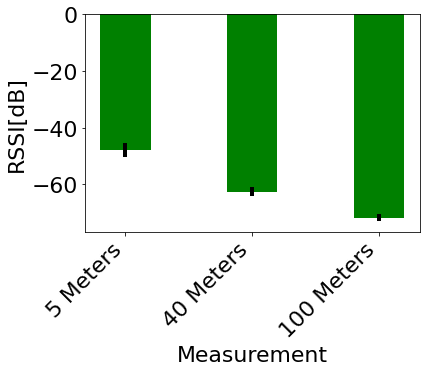

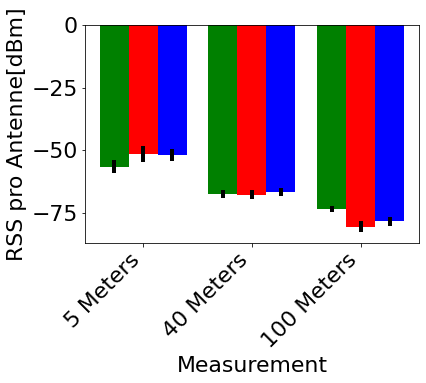

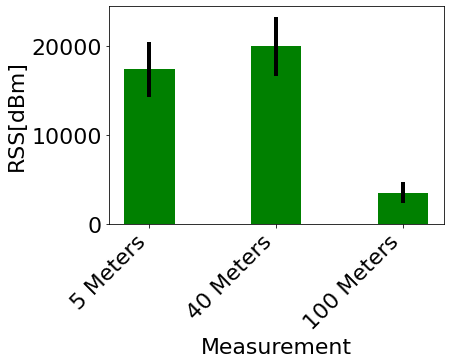

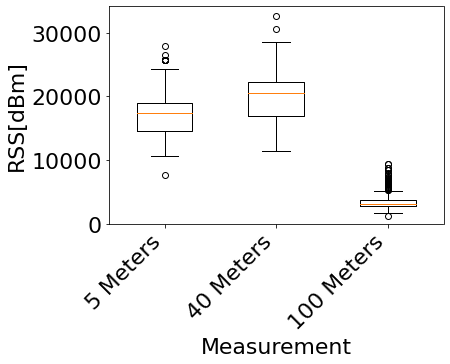

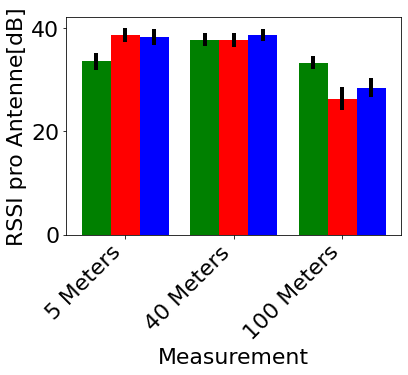

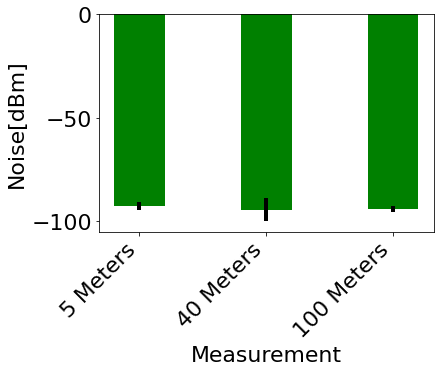

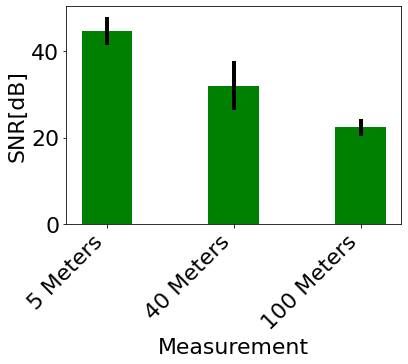

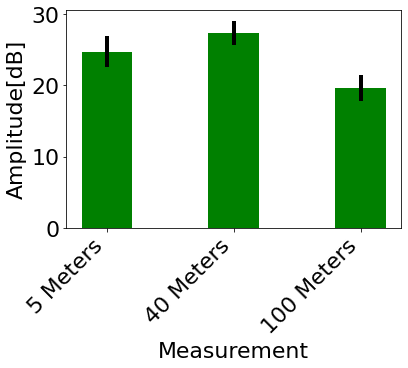

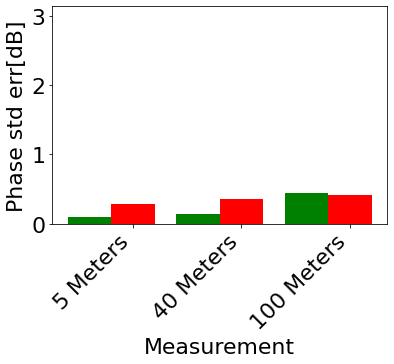

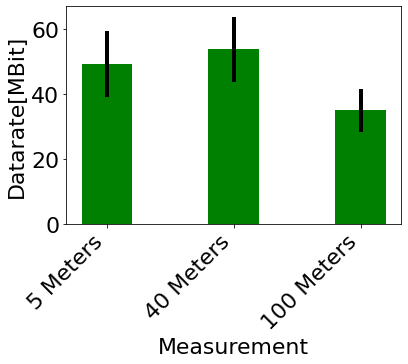

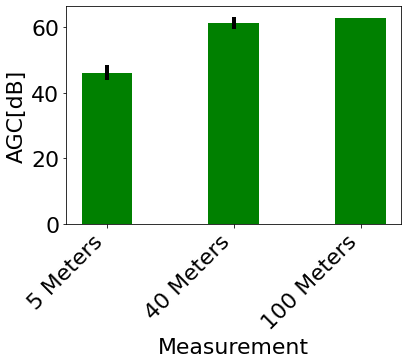

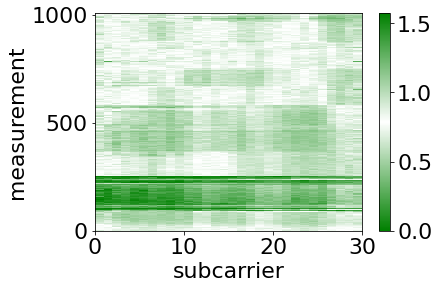

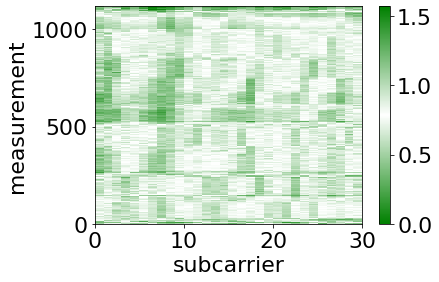

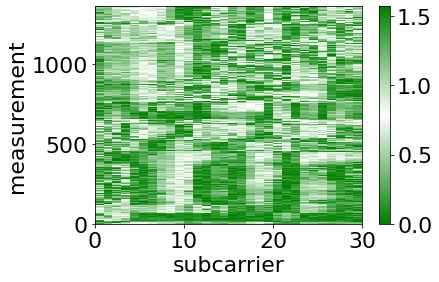

In [12]:
FILES = {
    "5 Meters"      :"../CSIKit/visualization/example_dat/los_5.dat",
    "40 Meters"     :"../CSIKit/visualization/example_dat/los_40.dat",
    "100 Meters"    :"../CSIKit/visualization/example_dat/los_100.dat",
}

scenario = ScenarioPlotter("name_to_save_pdf", PLOT_CLASSES)
scenario.add_measurements_files(FILES)
scenario.show()

## Save plots as PDF

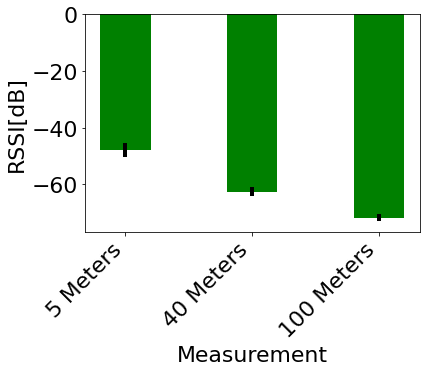

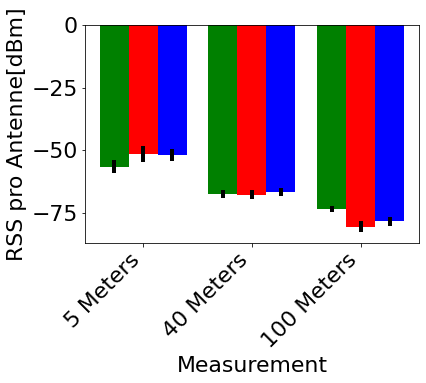

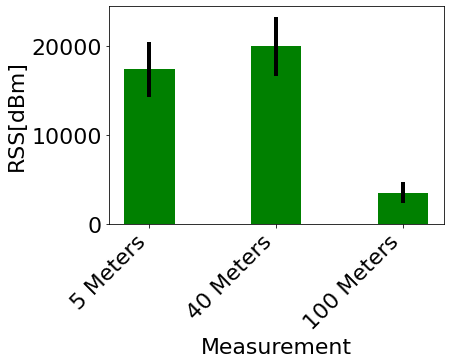

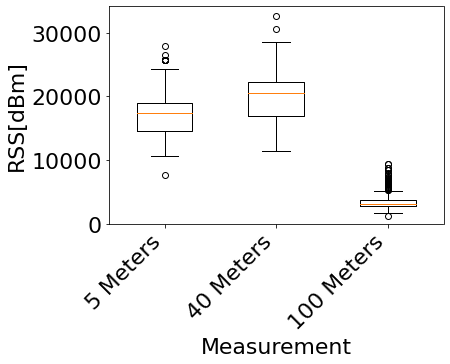

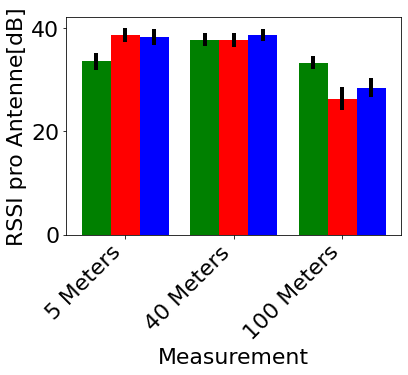

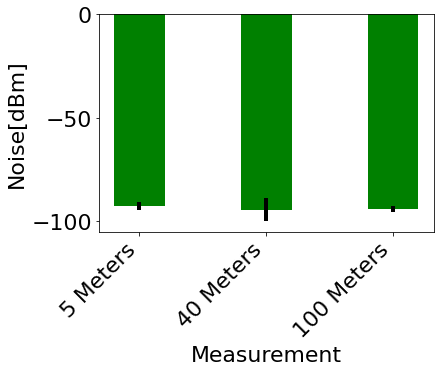

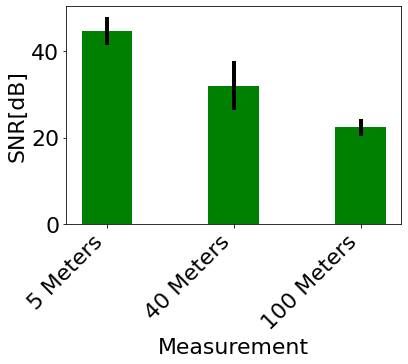

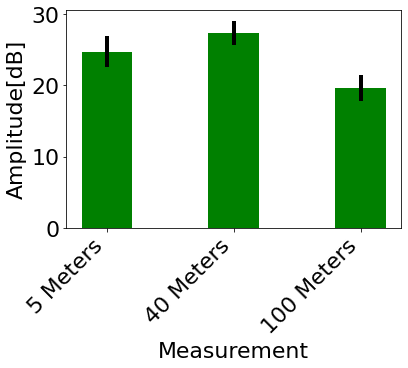

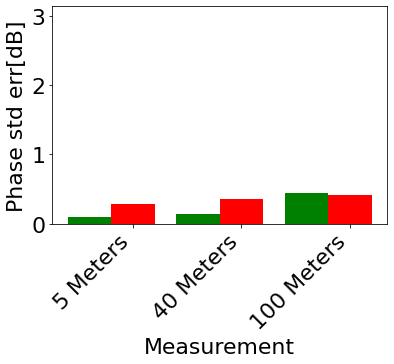

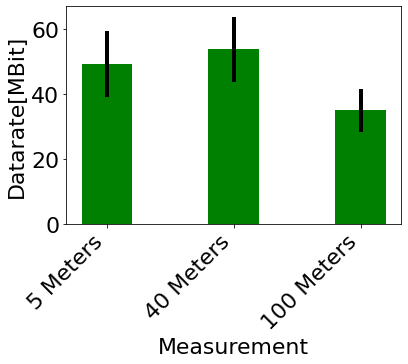

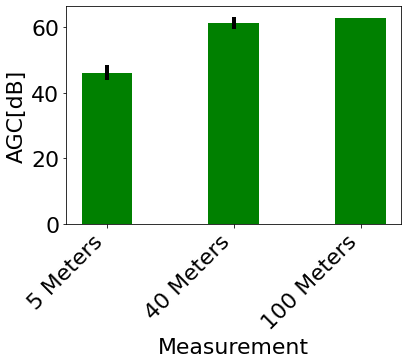

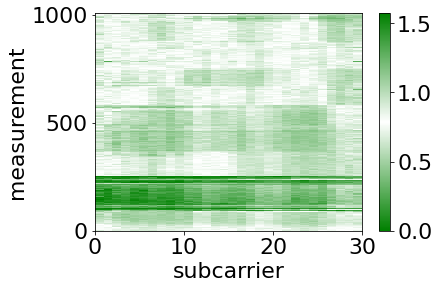

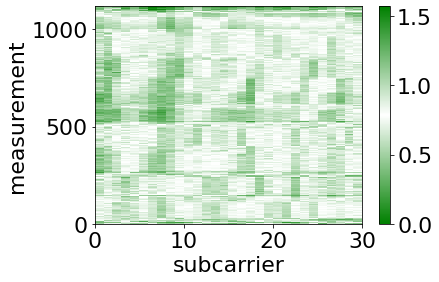

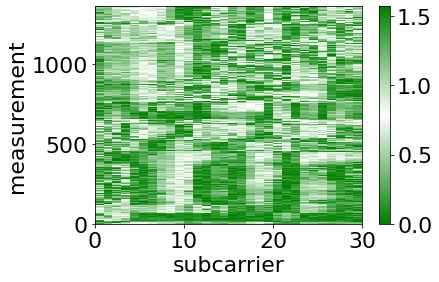

In [18]:
scenario.save(folder="output")
plt.close()

## Write own Metric

In [14]:


class Noise(Metric):
    def notice(self, entry:CsiEntry):
        return entry.noise
    def get_name(self):
        return "Noise"
    def get_unit(self):
        return "dBm"



## Write own Graph
to implement your own graph, implement the show method at Graph and use the given matplotlib **axes** and values with the shape of 
``` python
{
    "<measurement_name1>" : entires:list[Frames],
    "<measurement_name2>" : entires:list[Frames],
    (...)
}
```
Following the implementation of PlotBox

In [15]:
class PlotColorMap(Graph):
    def __init__(self, metric):
        super().__init__(metric)
        self.vmin=None
        self.vmax=None
        self.cmap = plt.cm.plasma
        self.color_legend = True
    def _plot_axes(self,  values_per_measurement):

        for measur_name in values_per_measurement:
            axes = self._create_new_ax()
            amplitude_per_sub = values_per_measurement[measur_name]
            amplitude_per_sub = np.matrix(np.array(amplitude_per_sub))
             # plot
            cmap= self.cmap
            if not self.vmin is None and not self.vmax is None:
                pcmap = axes.pcolormesh(amplitude_per_sub, cmap=cmap,  vmin=self.vmin, vmax=self.vmax,rasterized=True)
            else:
                pcmap = axes.pcolormesh(amplitude_per_sub, cmap=cmap, rasterized=True)
            if self.color_legend:
                plt.colorbar(pcmap, ax=axes)
            axes.set_xlabel(f"subcarrier")
            axes.set_ylabel('measurement')
            plt.show()